## Logistic regression with MNIST

### Libraries

In [1]:
# libraries
using Flux              # the julia ml library
using Images            # image processing and machine vision for julia
using MLJ               # make_blobs, rmse, confmat, categorical
using MLDataUtils       # label, nlabel, labelfreq
using MLDatasets        # mnist

# using MLJLinearModels   # LogisticClassifier

using LinearAlgebra     # pinv pseudo-inverse matrix
using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

using CSV
using DataFrames


### Functions

In [2]:
# functions for feature extraction
meanIntensity(img) = mean(Float64.(img))

function hSymmetry(img)
    imgFloat = Float64.(img)
    imgReverse = reverse(imgFloat, dims=1)
    return -mean( abs.(imgFloat - imgReverse) )
end

hSymmetry (generic function with 1 method)

In [3]:
# lib functions
image2Vector(M) = vec(Float64.(M))

function batchImage2Vector(imagesArray3D)
    h, v, N = size(imagesArray3D)
    vectorOfImageVectors = [ image2Vector( imagesArray3D[:, :, i] ) for i in 1:N]
end

vector2Image(vec, h, v) = reshape(Float64.(vec), (h, v))

function rescaleByColumns(X)
    # using StatsBase
    X = Float64.(X)
    dt = StatsBase.fit(ZScoreTransform, X; dims=1, center=true, scale=true)
    rescaledX = StatsBase.transform(dt, X)
end


rescaleByColumns (generic function with 1 method)

### MNIST data

,,,,

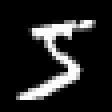
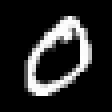
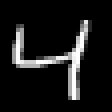
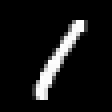
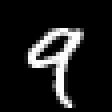

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [4]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [5]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

### Logistic classification (two classes - two predictors)

In [6]:
# convert images to vectors
trainX = batchImage2Vector(trainX)
trainX[1:5]

5-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [7]:
# select classes for prediction
c = (1, 5)

# data selection from above classes and sizes
trainX = vcat( trainX[trainY .== c[1] ], trainX[ trainY .== c[2] ] )
trainY = vcat( trainY[trainY .== c[1] ], trainY[ trainY .== c[2] ] )
display(levels(trainY))
size(trainX), size(trainY)

2-element Vector{Int64}:
 1
 5

((8514,), (8514,))

In [32]:
# generate predictors and outcome
function generatePredictors(X)
    N = size(X)[1]
    x1 = [meanIntensity(X[i]) for i in 1:N]
    x2 = [hSymmetry(X[i])     for i in 1:N]
    Xs = hcat(x1, x2)
    Xs = rescaleByColumns(Xs)
    
    return Xs
end

trainXLog = generatePredictors(trainX)
trainYLog = copy(trainY);


In [33]:
#using ScientificTypes
# specific conversions for model to be fit
trainXLog = DataFrame(trainXLog, :auto)
#trainXLog = MLJ.coerce(trainXLog)
#trainXLog = [ image2Vector( trainXLog[i, :] ) for i in 1:N]

trainYLog = categorical(trainYLog);

In [34]:
scitype(trainXLog)

Table{AbstractVector{ScientificTypesBase.Continuous}}

In [37]:
# load the package
LogisticClassifier = @load LogisticClassifier pkg=MLJLinearModels verbosity=0

MLJLinearModels.LogisticClassifier

In [38]:
# instantiate the model
# in the context of MLJ, "model" means simply a container for hyper parameters
model = LogisticClassifier()

LogisticClassifier(
    lambda = 1.0,
    gamma = 0.0,
    penalty = :l2,
    fit_intercept = true,
    penalize_intercept = false,
    scale_penalty_with_samples = true,
    solver = nothing)

In [40]:
# "machine" actually means the outcome object of the learning parameters
mach = MLJ.machine(model, trainXLog, trainYLog)

Machine{LogisticClassifier,…} trained 0 times; caches data
  model: MLJLinearModels.LogisticClassifier
  args: 
    1:	Source @866 ⏎ `Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @603 ⏎ `AbstractVector{Multiclass{2}}`


In [43]:
# train the machine
fit!(mach)

┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/CglMw/src/machines.jl:464


Machine{LogisticClassifier,…} trained 1 time; caches data
  model: MLJLinearModels.LogisticClassifier
  args: 
    1:	Source @866 ⏎ `Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @603 ⏎ `AbstractVector{Multiclass{2}}`


In [46]:
# predict
ŷ = MLJ.predict(mach, rows=trainXLog)

LoadError: ArgumentError: invalid index: 8514×2 DataFrame
  Row │ x1           x2
      │ Float64      Float64
──────┼─────────────────────────
    1 │ -0.754948     0.550307
    2 │ -1.12983      1.39845
    3 │ -1.02926      1.38226
    4 │ -0.656764     0.612189
    5 │ -1.18339      0.416763
    6 │ -0.732319     0.241739
    7 │ -0.0862636    0.425362
    8 │ -1.22236      0.665977
    9 │ -0.570774     0.513717
   10 │ -1.09174      0.230105
   11 │ -0.306016     1.1295
  ⋮   │      ⋮           ⋮
 8505 │  1.75749     -1.44223
 8506 │ -0.765508     0.054238
 8507 │  0.00840075  -0.273215
 8508 │  1.03098     -0.511975
 8509 │  1.20195     -1.48658
 8510 │  0.650685    -0.910752
 8511 │  0.369206    -0.337963
 8512 │  0.515414    -1.00046
 8513 │  1.54063     -0.46139
 8514 │  2.10283     -2.12125
               8493 rows omitted of type DataFrame